In [1]:
import random
import time
from concurrent.futures import ThreadPoolExecutor
from queue import PriorityQueue


In [22]:
class Task:
    def __init__(self, name, service_time, arrival_time):
        self.name = name
        self.service_time = random.expovariate(1 / service_time)
        self.priority = self.generate_priority()
        self.arrival_time = arrival_time
        
    def generate_priority(self):
        r = random.random()
        if r <= 0.2:
            return 'high'
        elif r <= 0.5:
            return 'medium'
        else:
            return 'low'

    def __lt__(self, other):
        return self.service_time < other.service_time


In [23]:
def task_generator(T, lambda_param):
    current_time = 0
    task_count = 0
    while current_time < T:
        task_count += 1
        inter_arrival_time = random.expovariate(lambda_param)
        current_time += inter_arrival_time
        yield Task(f"Task {task_count}", inter_arrival_time, current_time)


In [24]:
def process_task(queue, policy):
    if policy == 'fifo':
        task = fifo_policy(queue)
    elif policy == 'weighted_round_robin':
        task = weighted_round_robin_policy(queue)
    elif policy == 'non_preemptive_priority':
        task = non_preemptive_priority_policy(queue)
    else:
        raise ValueError(f"Unknown policy: {policy}")

    if task:
        time_in_queue = time.time() - task.arrival_time
        time.sleep(task.service_time)
        print(f"{task.name} with priority {task.priority} is processed")
        if task.priority == 'high':
            return time_in_queue
        else:
            return None


In [25]:
def fifo_policy(queue):
    return queue.get()

def weighted_round_robin_policy(queue):
    high_priority = [task for task in queue.queue if task.priority == 'high']
    medium_priority = [task for task in queue.queue if task.priority == 'medium']
    low_priority = [task for task in queue.queue if task.priority == 'low']
    if high_priority:
        return high_priority.pop(0)
    elif medium_priority:
        return medium_priority.pop(0)
    elif low_priority:
        return low_priority.pop(0)
    else:
        return None

def non_preemptive_priority_policy(queue):
    sorted_tasks = sorted(queue.queue, key=lambda task: task.priority)
    task = sorted_tasks.pop(0)
    queue.queue.remove(task)
    return task


In [26]:
def run_simulation(T, k, lambda_param, max_queue_size, policy):
    task_queues = [PriorityQueue(maxsize=max_queue_size) for _ in range(k)]
    dropped_tasks = 0
    total_tasks = 0
    total_queue_sizes = [0] * k
    total_task_times = [0] * k
    server_busy_times = [0] * k
    task_arrival_times = []

    start_time = time.time()
    with ThreadPoolExecutor(max_workers=k) as executor:
        for task in task_generator(T, lambda_param):
            high_priority_times = []
            total_tasks += 1
            task_arrival_times.append((total_tasks, time.time() - start_time))
            min_queue = min(task_queues, key=lambda q: q.qsize())
            if min_queue.full():
                dropped_tasks += 1
            else:
                min_queue_idx = task_queues.index(min_queue)
                total_queue_sizes[min_queue_idx] += 1
                total_task_times[min_queue_idx] += task.service_time
                server_busy_times[min_queue_idx] += task.service_time
                min_queue.put(task)
                time_in_queue = executor.submit(process_task, min_queue, policy).result()
                if time_in_queue is not None:
                    high_priority_times.append(time_in_queue)

    avg_queue_sizes = [size / total_tasks for size in total_queue_sizes]
    avg_time_spent_queues = [task_time / total_tasks for task_time in total_task_times]
    avg_server_utilization = [busy_time / T for busy_time in server_busy_times]

    return dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization, high_priority_times


In [31]:
T = 10  # 10 seconds of simulation time
k = 3  # 3 servers
lambda_param = 5  # Poisson distribution parameter
max_queue_size = 5  # Maximum queue size for each server
policy = 'weighted_round_robin'  # Choose from 'fifo', 'weighted_round_robin', or 'non_preemptive_priority'

dropped_tasks, total_tasks, avg_queue_sizes, avg_time_spent_queues, avg_server_utilization,high_priority_times = run_simulation(T, k, lambda_param, max_queue_size, policy)
print(f"Total tasks generated: {total_tasks}")
print(f"Dropped tasks: {dropped_tasks}")
print(f"Average queue sizes: {avg_queue_sizes}")
print(f"Average time spent in all queues: {sum(avg_time_spent_queues) / len(avg_time_spent_queues)}")
print(f"Average time spent in each queue: {avg_time_spent_queues}")
print(f"Average server utilization: {avg_server_utilization}")


Task 1 with priority medium is processed
Task 2 with priority low is processed
Task 3 with priority low is processed
Task 4 with priority medium is processed
Task 5 with priority low is processed
Task 6 with priority low is processed
Task 4 with priority medium is processed
Task 8 with priority low is processed
Task 9 with priority medium is processed
Task 4 with priority medium is processed
Task 8 with priority low is processed
Task 9 with priority medium is processed
Task 13 with priority high is processed
Task 14 with priority medium is processed
Task 9 with priority medium is processed
Total tasks generated: 48
Dropped tasks: 33
Average queue sizes: [0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
Average time spent in all queues: 0.02419452734499465
Average time spent in each queue: [0.038475787962313074, 0.005437917678139579, 0.028669876394531297]
Average server utilization: [0.18468378221910275, 0.026102004855069978, 0.13761540669375022]


In [34]:
scheduling_policies = ['fifo', 'weighted_round_robin', 'non_preemptive_priority']
high_priority_times_by_policy = {}

for policy in scheduling_policies:
    _, _, _, _, _, high_priority_times = run_simulation(T, k, lambda_param, max_queue_size, policy)
    high_priority_times_by_policy[policy] = high_priority_times

Task 1 with priority medium is processed
Task 2 with priority medium is processed
Task 3 with priority medium is processed
Task 4 with priority medium is processed
Task 5 with priority low is processed
Task 6 with priority low is processed
Task 7 with priority high is processed
Task 8 with priority low is processed
Task 9 with priority low is processed
Task 10 with priority high is processed
Task 11 with priority low is processed
Task 12 with priority low is processed
Task 13 with priority low is processed
Task 14 with priority low is processed
Task 15 with priority low is processed
Task 16 with priority medium is processed
Task 17 with priority medium is processed
Task 18 with priority medium is processed
Task 19 with priority medium is processed
Task 20 with priority medium is processed
Task 21 with priority low is processed
Task 22 with priority low is processed
Task 23 with priority medium is processed
Task 24 with priority medium is processed
Task 25 with priority medium is proces

fifo: []
weighted_round_robin: []
non_preemptive_priority: []


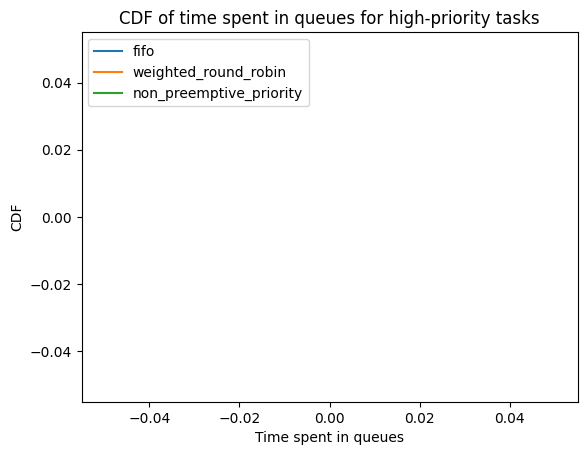

In [38]:
import matplotlib.pyplot as plt
import numpy as np
for policy, high_priority_times in high_priority_times_by_policy.items():
    print(f"{policy}: {high_priority_times}")
for policy, high_priority_times in high_priority_times_by_policy.items():
    sorted_times = np.sort(high_priority_times)
    yvals = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    plt.plot(sorted_times, yvals, label=policy)

plt.xlabel('Time spent in queues')
plt.ylabel('CDF')
plt.legend(loc='upper left')
plt.title('CDF of time spent in queues for high-priority tasks')
plt.show()
